[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pharringtonp19/rfp/blob/main/notebooks-scripts/training%20/standard_training.ipynb)


#### **Uncomment this to Install Necessary Libraries**

In [1]:
# !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install optax flax tqdm 
# !pip install git+https://github.com/pharringtonp19/rfp
# !pip install matplotlib

#### **Import Libraries**

In [2]:
import jax 
import jax.numpy as jnp
import optax 
import matplotlib.pyplot as plt
from pathlib import Path
from functools import partial 
import os 
import flax 
import numpy as np
from rfp import MLP, Model, ModelParams
from rfp.utils import batch_matrix_with_padding
from rfp.losses import binary_cross_entropy, Supervised_Loss, mse
from rfp.train import Trainer
import pickle 
from collections import OrderedDict
from tqdm import tqdm
import pickle
import textwrap
import jax
import pandas as pd 
jax.config.update("jax_debug_nans", True)
import math

#### **Colab Indicator**

In [3]:
colab = True 

#### **Define Paths**

In [4]:
base_folder = str(Path(os.getcwd()).parent.parent.parent.absolute())
save_folder = base_folder + f"/evictions/data_np/outcomes/"
if colab:
    import_data_link = "./../../toy-data/mse_data.csv" # './mse_data.csv'
else:
    import_data_link = base_folder + f"/evictions/data_np/prompt_scraped_data_False.npz"
print(base_folder)

/home/ubuntu


#### **Plotting**

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

if not colab:


    from matplotlib import font_manager 
    locations = base_folder + '/rfp/styles/Newsreader'
    font_files = font_manager.findSystemFonts(fontpaths=locations)
    print(locations)
    print(font_files[0])
    for f in font_files: 
        font_manager.fontManager.addfont(f)
    plt.rcParams["font.family"] = "Newsreader"

#### **Parameterize Notebook**

In [6]:
outcome_label = 'outcome'
outcome_documents = {
                    'outcome': 
                        {'outcome_status': 'continuous', 
                        'plot_labels':['Treatment Effects', 'Untreated Potential Outcome', 'Feature'],
                        'scale_factor': 1.0},
                    'possession': 
                        {'outcome_status': 'binary',
                        'plot_labels':['Effect of Legal Aid on Possession', 'Possession', 'Rent'],
                        'scale_factor': 0.12},
                    'poverty_change': 
                        {'outcome_status': 'continuous',
                        'plot_labels':['Effect of Legal Aid on Poverty Change', 'Poverty Rate', 'Rent'],
                        'scale_factor': 0.12},
                    'legalaid': 
                        {'outcome_status': 'binary',
                         'plot_labels': ['Effect of RTC on Legal Aid', 'Legal Aid Status Quo', 'Rent'],
                         'scale_factor': 1.0},
                    'moved': 
                        {'outcome_status': 'binary', 
                         'plot_labels': ['Effect of Legal Aid on Observed Moved', 'Observed Move', 'Rent'],
                         'scale_factor': 0.12}}
outcome_status = outcome_documents[outcome_label]['outcome_status']
plot_labels = outcome_documents[outcome_label]['plot_labels']
scale_factor = outcome_documents[outcome_label]['scale_factor']
covariates_label = 'Four'
causal_variable = 'treatment'
split_frac = 0.5
sims = 50
outer_epochs = 1000
nodes = 32
lr = 0.01

#### **Read In Data**

In [7]:
if not colab:
    # Load numpy data
    loaded_data = np.load(import_data_link, allow_pickle=True)

    # Feature Matrix
    X = loaded_data[covariates_label][:,1:]

    # Target
    Y = loaded_data[outcome_label]

    # Causal Variable
    Z = loaded_data[causal_variable]
else:
    
    df = pd.read_csv(import_data_link)
    X = jnp.array(df['features'].values.reshape(-1,1))
    Z = jnp.array(df['causal'].values.reshape(-1,1))
    Y = jnp.array(df['outcome'].values.reshape(-1,1))

2024-04-17 13:43:17.697742: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


#### **Process Data**

In [8]:
# Feature Matrix
min_val = jnp.min(X, axis=0)
max_val = jnp.max(X, axis=0)
X_normalized = (X - min_val) / (max_val - min_val)
print(f"Feature shape: \t\t{X.shape}")

# Target
print(f"Outcome Shape: \t\t{Y.shape}")
if outcome_status == 'continuous':
    Y_mean = jnp.mean(Y)
    Y_std = jnp.std(Y)
    Y_normalized = (Y - Y_mean)/Y_std
else:
    Y_mean = 0.0
    Y_std = 1.0
    Y_normalized = (Y - Y_mean)/Y_std

# Causal Variable
print(f"Causal Variable Shape:  {Z.shape}")

# Treatment ++ Instrument 
XZ_normalized = jnp.hstack([X_normalized, Z]) 

if not colab:
    sample_weights =  loaded_data['sample_weight']
    print(f"Weight Shape: \t\t{sample_weights.shape}\n\n")

else:
    sample_weights = jnp.ones(shape=(Z.shape[0],))

print(f"Min 'Raw' sample weight: {jnp.min(sample_weights)}, Max 'Raw' sample weight: {jnp.max(sample_weights)}")
normalized_weights = sample_weights / jnp.sum(sample_weights)

Feature shape: 		(1000, 1)
Outcome Shape: 		(1000, 1)
Causal Variable Shape:  (1000, 1)
Min 'Raw' sample weight: 1.0, Max 'Raw' sample weight: 1.0


#### **Model Setup**

In [9]:
features = XZ_normalized.shape[1] ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes], jax.nn.relu)
final_activation_fn = jax.nn.sigmoid if outcome_status == 'binary' else lambda x: x; print(f"Final Activation Function: {final_activation_fn}")
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(binary_cross_entropy if outcome_status == 'binary' else mse, model.embellished_fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), outer_epochs)

Number of Features: 2
Final Activation Function: <function <lambda> at 0x7fbbb1f68700>


#### **Initial Predictions**

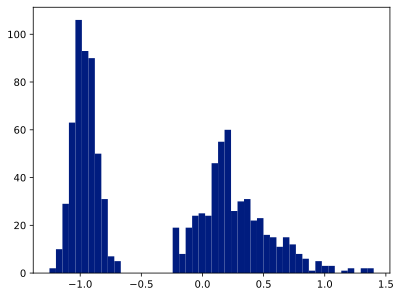

In [10]:
def hist_predictions(key):
    params = ModelParams.init_fn(key, mlp, features)
    yhat = model.fwd_pass(params, XZ_normalized)
    plt.hist(yhat.reshape(-1,), bins=50)
    plt.show()

hist_predictions(jax.random.PRNGKey(0))

#### **Training**

In [11]:
StandardResults = {}
key = jax.random.PRNGKey(0)
for i in tqdm(range(sims)):

    # Create Keys
    key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)

    # Initialize the parameters
    params = ModelParams.init_fn(subkey1, mlp, features)

    # Split Train and Validation Data
    idx = jax.random.permutation(subkey2, XZ_normalized.shape[0])

    # Training Indices
    train_idx = idx[:int(split_frac * XZ_normalized.shape[0])]
    p_train = normalized_weights[train_idx]/jnp.sum(normalized_weights[train_idx])
    train_idx = jax.random.choice(subkey3, train_idx, shape=(train_idx.shape[0],), p=p_train)
    is_in_train = jnp.isin(jnp.arange(XZ_normalized.shape[0]), train_idx)                                   # Check if the index is in the validation set

    # Validation Indices
    val_idx = idx[int(split_frac * XZ_normalized.shape[0]):]
    p_val = normalized_weights[val_idx]/jnp.sum(normalized_weights[val_idx])
    val_idx = jax.random.choice(subkey4, val_idx, shape=(val_idx.shape[0],), p=p_val)
    is_in_val = jnp.isin(jnp.arange(XZ_normalized.shape[0]), val_idx)                                   # Check if the index is in the validation set

    # Train the model
    params, opt_params, train_loss_history, val_loss_history = yuri.train_with_val(params, XZ_normalized, Y_normalized, jnp.ones_like(Y_normalized), is_in_train, is_in_val)
    StandardResults[i] = {'params': opt_params, 
                          'train_loss_history': train_loss_history, 
                          'val_loss_history': val_loss_history,
                          'val_idx': is_in_val}

100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


#### **Visualize Training Runs**

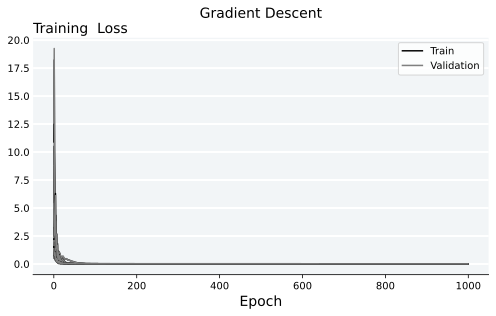

In [12]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Gradient Descent', size=14, loc='center', pad=20)

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Training  Loss', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
for i in range(jnp.minimum(10, sims)):
    if i == 1:
        plt.plot(StandardResults[i]['train_loss_history'], color='black', label='Train')
        plt.plot(StandardResults[i]['val_loss_history'], color='grey', label='Validation')
    else:
        plt.plot(StandardResults[i]['train_loss_history'], color='black')
        plt.plot(StandardResults[i]['val_loss_history'], color='grey')
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()

#### **Out of Sample Predictions**

In [13]:
r1 = (jnp.hstack([model.fwd_pass(StandardResults[i]['params'], jnp.hstack((X_normalized, jnp.ones_like(Z)))) for i in range(sims)]) * Y_std) + Y_mean
r0 = (jnp.hstack([model.fwd_pass(StandardResults[i]['params'], jnp.hstack((X_normalized, jnp.zeros_like(Z)))) for i in range(sims)])* Y_std) + Y_mean
idx = jnp.hstack([StandardResults[i]['val_idx'].reshape(-1,1) for i in range(sims)])
avg1 = jnp.sum(r1 * idx, axis=1)/ jnp.sum(idx, axis=1)
avg0 = jnp.sum(r0 * idx, axis=1)/ jnp.sum(idx, axis=1)
print(jnp.mean(avg1 - avg0))

if not colab:
    # Save Results
    np.savez_compressed(save_folder + f'{outcome_label}_standard.npz', avg_diff=avg1-avg0, avg1=avg1, avg0=avg0)

# Individual Results (Scaled)
indv_effect = (avg1-avg0)/scale_factor

-0.010155188


#### **Plot Effect**

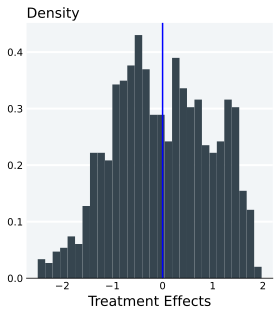

In [14]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist( (avg1 - avg0)/scale_factor, color='#36454F', density=True, bins=30)
if scale_factor != 1:
    ax.annotate('* ITT(x) scaled by fstage estimate',
            xy = (0., -0.15),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=8)
plt.axvline(0, color='blue')
plt.xlabel(plot_labels[0], size=14)
plt.show()


#### **Treatment Heterogeneity by $\tilde{Y}_i(0)$ or Control Variable**

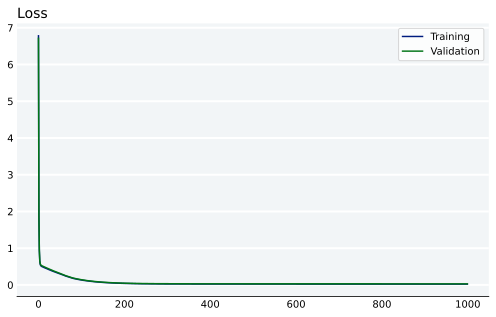

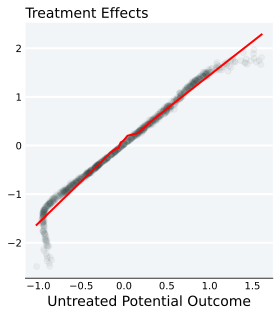

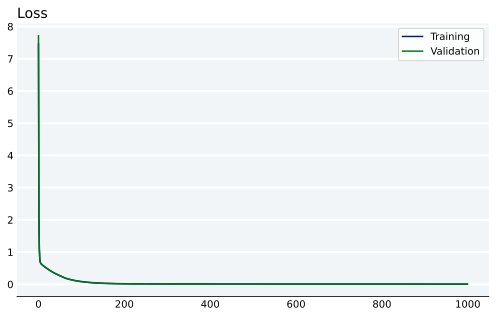

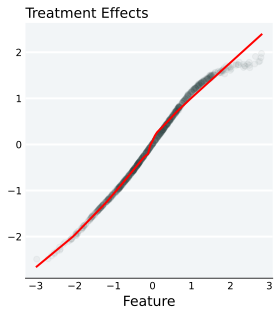

In [15]:
y_axis_variables = [indv_effect, indv_effect]
if colab:
    x_axis_variables = [avg0, X]
else:
    x_axis_variables = [avg0,jnp.exp(X[:,jnp.argmax(X[0])])]

for y_axis_variable, x_axis_variable, xlabel in zip(y_axis_variables, x_axis_variables, plot_labels[1:]):  
    # Standardize Variables 
    y_axis_variable_mean, y_axis_variable_std =  jnp.mean(y_axis_variable), jnp.std(y_axis_variable)
    y_axis_variable_normalized = (y_axis_variable - y_axis_variable_mean) / y_axis_variable_std
    x_axis_variable_mean, x_axis_variable_std =  jnp.mean(x_axis_variable), jnp.std(x_axis_variable)
    x_axis_variable_normalized = (x_axis_variable - x_axis_variable_mean) / x_axis_variable_std

    # Fit NN over 1-Dimensional Input
    features = 1
    outer_epochs = 1000
    mlp = MLP([32, 32], jax.nn.relu)
    loess_model = Model(mlp, lambda x: x)
    supervised_loss = Supervised_Loss(mse, loess_model.embellished_fwd_pass, reg_value=0, aux_status=False)
    outer_lr = 0.001
    yuri = Trainer(supervised_loss, optax.sgd(learning_rate=outer_lr), outer_epochs)
    params = ModelParams.init_fn(jax.random.PRNGKey(0), mlp, features)
    idx = jax.random.permutation(jax.random.PRNGKey(0), jnp.arange(x_axis_variable_normalized.shape[0]))
    train_idx = jnp.isin(idx, idx[:int(.8*idx.shape[0])])
    val_idx = jnp.isin(idx, idx[int(.8*idx.shape[0]):])
    _, params, train_loss, val_loss  = yuri.train_with_val(params, x_axis_variable_normalized.reshape(-1,1) , y_axis_variable_normalized.reshape(-1,1), jnp.ones_like(y_axis_variable_normalized).reshape(-1,1), train_idx, val_idx)


    # Plot Training Results
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    ax.text(0., 1.02, s='Loss', transform=ax.transAxes, size=14)
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)
    plt.plot(train_loss, label='Training')
    plt.plot(val_loss, label='Validation')
    plt.legend()
    plt.show()

    # Plot Results
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    ax.text(0., 1.02, s= plot_labels[0], transform=ax.transAxes, size=14)
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    plt.scatter(x_axis_variable, y_axis_variable, color='#36454F', alpha=0.05)
    xs = jnp.linspace(jnp.min(x_axis_variable), jnp.max(x_axis_variable), 100)
    xs_normalized = (xs - x_axis_variable_mean) / x_axis_variable_std
    ys =  (loess_model.fwd_pass(params, xs_normalized.reshape(-1,1))) * y_axis_variable_std + y_axis_variable_mean
    plt.plot(xs, ys, color='red', linewidth=2, linestyle='-')
    #plt.ylim( jnp.minimum(jnp.min( avg1-avg0)- 0.05, 0.0), jnp.max( avg1-avg0)+ 0.05)
    plt.xlabel(xlabel, size=14)
    if scale_factor != 1:
        ax.annotate('* ITT(x) scaled by fstage estimate',
                xy = (0., -0.15),
                xycoords='axes fraction',
                ha='left',
                va="center",
                fontsize=8)
    plt.show()

In [16]:
if not colab:
    if outcome_label == 'poverty_change':
        moved_data = np.load(save_folder  + 'moved_standard.npz')
        m0 = moved_data['avg0']

        target_variable = target_variable = jnp.array([jnp.mean(avg1 - avg0, where=avg0>=i) for i in avg0])
        base_variable = m0 
        base_label = 'Likelihood of Observed Move'

        base_mean, base_std = jnp.mean(base_variable), jnp.std(base_variable)
        base_variable_train = (base_variable - base_mean) / base_std
        target_mean, target_std =  jnp.mean(target_variable), jnp.std(target_variable)
        target_variable_train = (target_variable - target_mean) / target_std
        features = 1
        outer_epochs = 1000
        mlp = MLP([32, 32], jax.nn.relu)
        loess_model = Model(mlp, lambda x: x)
        supervised_loss = Supervised_Loss(mse, loess_model.embellished_fwd_pass, reg_value=0, aux_status=False)
        outer_lr = 0.001
        yuri = Trainer(supervised_loss, optax.sgd(learning_rate=outer_lr), outer_epochs)
        params = ModelParams.init_fn(jax.random.PRNGKey(0), mlp, features)
        idx = jax.random.permutation(jax.random.PRNGKey(0), jnp.arange(base_variable_train.shape[0]))
        train_idx = jnp.isin(idx, idx[:int(.8*idx.shape[0])])
        val_idx = jnp.isin(idx, idx[int(.8*idx.shape[0]):])
        _, params, train_loss, val_loss  = yuri.train_with_val(params, base_variable_train.reshape(-1,1) , target_variable_train.reshape(-1,1), jnp.ones_like(avg0).reshape(-1,1), train_idx, val_idx)

        plt.plot(train_loss)
        plt.plot(val_loss)
        plt.show()

        fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
        ax = plt.axes(facecolor=(.95, .96, .97))
        ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

        for key in 'left', 'right', 'top':
            ax.spines[key].set_visible(False)

        ax.text(0., 1.02, s= plot_labels[0], transform=ax.transAxes, size=14)
        ax.yaxis.set_tick_params(length=0)
        ax.yaxis.grid(True, color='white', linewidth=2)
        ax.set_axisbelow(True)

        plt.scatter(base_variable, target_variable, color='#36454F')
        xs = jnp.linspace(jnp.min(base_variable), jnp.max(base_variable), 100)
        xs_train = (xs - base_mean) / base_std
        ys_train =  loess_model.fwd_pass(params, xs_train.reshape(-1,1))
        ys = (ys_train*target_std + target_mean)
        plt.plot(xs, ys, color='red', linewidth=2, linestyle='-')
        #plt.ylim( jnp.minimum(jnp.min( avg1-avg0)- 0.05, 0.0), jnp.max( avg1-avg0)+ 0.05)
        plt.xlabel(base_label, size=14)
        plt.show()

In [17]:
if not colab:
    StandardResults['Estimated_Effect'] = []
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes()
    ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    ax.text(0., 1.02, s='P(Outcome=1|X, Z=1)', transform=ax.transAxes, size=14)
    ax.yaxis.set_tick_params(length=2)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)


    value = 0.0
    cutoff0 = jnp.quantile(r0, 0.999).item()
    cutoff1 = jnp.quantile(r1, 0.999).item()
    for k in range(8):
        xs = jnp.linspace(0, cutoff0, 100)
        ys = jax.vmap(lambda x: x + value)(xs)
        plt.plot(xs, ys, linestyle='--', linewidth=1, color='grey')
        ax.annotate(f"{value:.2f}", (cutoff0, cutoff0 + value), color='black', fontsize=8)
        value += 0.05
    ax.annotate("Effect", (cutoff0, cutoff0 + value) , color='black', fontsize=8, weight='bold')

    for i in tqdm(range(jnp.minimum(sims, 10))):
        outcome1 = model.fwd_pass(StandardResults[i]['params'], jnp.hstack((X_normalized, jnp.ones_like(Z)))) 
        outcome0 =  model.fwd_pass(StandardResults[i]['params'], jnp.hstack((X_normalized, jnp.zeros_like(Z))) )

        Estimated_Effect = outcome1 - outcome0
        StandardResults['Estimated_Effect'].append(jnp.dot(Estimated_Effect.reshape(-1,), normalized_weights))
        
        plt.scatter(outcome0, outcome1, s=3, alpha=0.5)

    plt.xlabel("P(Outcome=1|X, Z=0)", size=14)
    plt.ylim(0, cutoff1+0.2)
    plt.xlim(0, cutoff0+0.05)
    plt.show()